## Return Probability of a Random Walk on the 3D Cubic Lattice

_(tv) 2015-12-11, 2020-06-30, 2022-01-04, 2024-06-10_

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import scipy.optimize

## Naïve Monte Carlo

As an instructive exercise, let us try to estimate the return probability for random walks on cubic lattices directly by Monte Carlo simulation. The straightforward (and slightly stupid) idea is to simply generate many random walks, and count how many of them return to the origin at some point. Interestingly, this can be coded in python/numpy with a few lines of code (although inefficiently).

In [6]:
def squareGrid(d):
    return (np.array(list(map(lambda e:(e,-e),np.identity (d,dtype="int")))).reshape(2*d,d))

In [15]:
rng = np.random.default_rng()

In [16]:
def MC_returns(d,L=L,N=N,Np=Np):
    """ calculates Np batches of N runs with length L """
    f = 0
    directions = squareGrid(d)
    for n in range(Np):
        x = rng.choice(directions,(L,N)) # the steps
        X = np.cumsum(x,axis=0)          # the positions
        Xn = np.sum(np.abs(X.T),axis=0)  # the L1 norms
        Xa = np.sum((Xn==0).any(axis=-1))
        f = f + Xa/N
    return f/Np

This code runs for a little while: you can try playing with the numbers for the length of the walks, and the ensemble sizes to average over. Discuss how the length affects the quality of the results!

In [54]:
mcdata = np.array([[d,MC_returns(d,L=5000,N=100,Np=100)] for d in range(1,7)])

For comparison, here are the known values (they are known as Pólya's random walk constants, see https://mathworld.wolfram.com/PolyasRandomWalkConstants.html):

In [30]:
polya = np.array([[1,1],[2,1],[3,0.340537],[4,0.193206],[5,0.135178],[6,0.104715]])

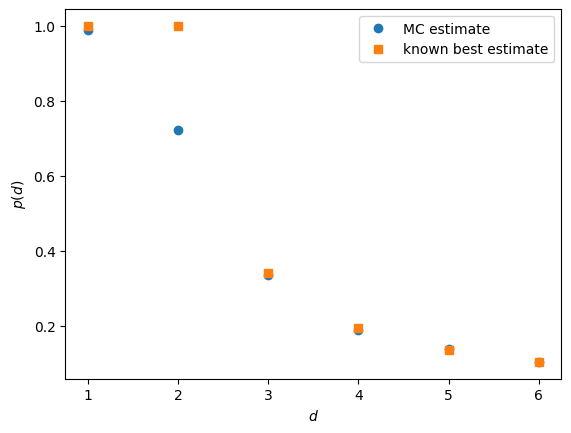

In [55]:
plt.plot(mcdata[:,0],mcdata[:,1],'o',label='MC estimate')
plt.plot(polya[:,0],polya[:,1],'s',label=r'known best estimate')
plt.xlabel(r'$d$')
plt.ylabel(r'$p(d)$')
plt.legend()
plt.show()

Let us try to make this a little bit better: in our code, we can keep all the runs that haven't returned after a fixed length, and continue to run them, counting also these. As it turns out, this does not really help, but the code is left here as an exercise to digest:

In [49]:
def MC_returns2_getf(X0,d,L,cnt=0):
    """ recursive helper for MC_returns2 """
    x = rng.choice(squareGrid(d),(L,len(X0)))
    X = X0 + np.cumsum(x,axis=0)
    Xn = np.sum(np.abs(X.T),axis=0)
    mask = (Xn==0).any(axis=-1)
    Xa = np.sum(mask)
    Xmasked = X[:,~mask,:] # these walks have not yet returned, continue them
    if len(X0)-Xa>0 and not cnt>100:
      Xa = Xa + MC_returns2_getf(Xmasked[-1],d,L,cnt+1)
    if cnt>0: return Xa
    else: return Xa/len(X0)
def MC_returns2(d,L=L,N=N,Np=Np):
    f = 0
    for n in range(Np):
        X0 = np.zeros((N,d),dtype="int")
        ff = MC_returns2_getf(X0,d,L)
        f = f + ff
    return f/Np

In [50]:
mcdata2 = np.array([[d,MC_returns(d,L=1000,N=1000,Np=100)] for d in range(1,4)])

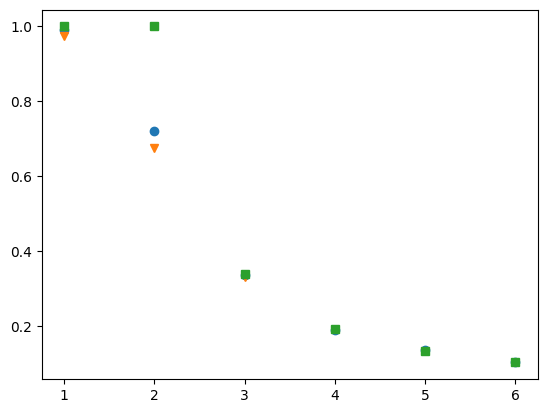

In [58]:
plt.plot(mcdata[:,0],mcdata[:,1],'o')
plt.plot(mcdata2[:,0],mcdata2[:,1],'v')
plt.plot(polya[:,0],polya[:,1],'s')
plt.show()

Note that in particular in $d=2$ our code does terribly. This is because $d=2$ is the marginal case: while the 2d random walk almost certainly returns to the origin, it takes an expected infinite number of steps to do so.

_Exercise:_ Think of ways to improve this simple-minded code. For example, we will have many walks that return to the origin very early but still are calculated with the same length as all the others. Also, we never do anything with the fact that some walks return multiple times. We could at least select the walks that have never returned and keep running them.

## Evaluation of exact formula in 3D

This notebook implements a direct evaluation of the formula for the return probability to a 3D random walk on the cubic lattice. We start by the probability $u_N$ that a return occurs at step $N$. Obviously, $N$ has to be even, and direct combinatorics leads to the formula (in 3D)
$$ u_{2n} = \frac{1}{6^{2n}} \sum_{j,k\le n}\frac{(2n)!}{j!j!k!k!(n-j-k)!(n-j-k)!}$$
The probability $f_N$ that a return occurs _for the first time_ at step $N$ is related to $u_N$ through the moment expansion (see lecture/tutorials). We are interested the probability of the walk to ever return, $f=\sum_Nf_N$.

We introduce the moment-generating functions $U(k)=\sum_{N=0}^\infty u_Nk^N$ and $F(k)=\sum_{N=0}^\infty f_Nk^N$. Since
$$ u_N=\sum_{M=0}^Nf_{M-N}u_M $$
by definition (with $u_0=1$ and $f_0=0$), we get, multiplying both sides with $k^N$ and summing all $N\ge1$: $U(k)-1=U(k)F(k)$, or $$F(k)=1-1/U(k)$$ with $f=F(1)$. Thus, if $U(1)=\sum_Nu_N$ diverges, the walk returns to the origin almost certainly. This is the case in 1D and 2D. Let us calculate the sum in 3D:

In [56]:
udirect = np.zeros(51)
udirect[0] = 1
for n in range(1,len(udirect)):
    un = 0
    fn = np.math.factorial(n)
    b2n = np.math.factorial(2*n)/fn/fn
    for k in range(n+1):
        fk = np.math.factorial(k)
        for j in range(0,n-k+1):
            fj = np.math.factorial(j)
            fnkj = np.math.factorial(n-k-j)
            un = un + b2n*np.power(fn/(fk*fj*fnkj),2)
    un = un * 1./6.**(2.*n)
    udirect[n] = un

One can estimate the large-$n$ behavior of this sum, and we verify that
$$ u_{2n}\sim\frac{1}{n^{3/2}} $$

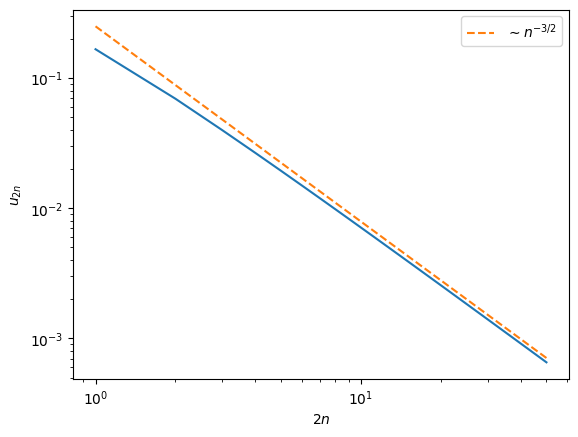

In [57]:
xr = np.arange(len(udirect))
plt.loglog(xr[1:],udirect[1:])
plt.loglog(xr[1:],0.25/np.power(xr[1:],1.5),ls='dashed',label=r'$\sim n^{-3/2}$')
plt.xlabel(r'$2n$')
plt.ylabel(r'$u_{2n}$')
plt.legend()
plt.show()

From $f=F(1)=1-1/U(1)$, we can estimate $f$ by the $n\to\infty$ limit of the accumulated sum:

In [59]:
fdirect = 1.-1./(np.cumsum(udirect))

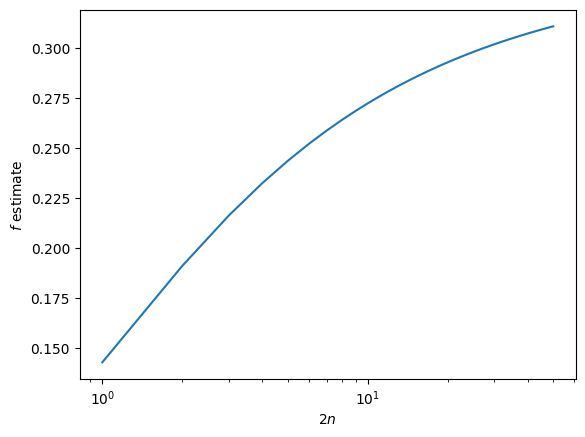

In [60]:
xr = np.arange(len(fdirect))
plt.plot(xr[1:],fdirect[1:])
plt.xscale('log')
plt.xlabel(r'$2n$')
plt.ylabel(r'$f$ estimate')
plt.show()

Note that the finite-$n$ values in the above plot do not have significance. We need to go to $n$ large enough so that the sum seems to have converged. As we can see, this is not yet the case.

The above naïve code runs into a problem: for large $n$, the factorials become too large for the computer. The trick is to use the Euler Gamma function, $\Gamma(n+1)=n!$ for integer $n$. The function $\ln\Gamma(n)$ can be evaluated directly, and this remains reasonably small. In our sum, we take case to apply the exponential only to arguments that are expected to remain within bounds.

This allows to calculate for large $n$. Note that the code still scales terribly, because of the double sum it has $\mathcal O(n^2)$ complexity. Try changing nmax in the code below. 

In [61]:
nmax = 200
udirect = np.zeros(nmax+1)
udirect[0] = 1
for n in range(1,len(udirect)):
    un = 0
    lfn = np.math.lgamma(n+1)
    lb2n = np.math.lgamma(2*n+1)-2*np.math.lgamma(n+1)
    for k in range(n+1):
        lfk = np.math.lgamma(k+1)
        for j in range(0,n-k+1):
            lfj = np.math.lgamma(j+1)
            lfnkj = np.math.lgamma(n-k-j+1)
            un = un + np.exp(lb2n+2*(lfn-lfk-lfj-lfnkj)-2*n*np.log(6.))
    udirect[n] = un

In [62]:
fdirect = 1.-1./(np.cumsum(udirect))

We can inspect that most likely, the values for $f$ have not yet converged. Assuming that the approach to the asymptotic value is power-law like, let us fit the large-$n$ portion of the calculated values to extract an estimate for $f$.

In [63]:
xr = np.arange(len(fdirect))
popt,pcov=scipy.optimize.curve_fit(lambda x,f,a,b: f-a*x**-b,xr[10:],fdirect[10:])
print ('fitted estimate f = {}'.format(popt[0]))

fitted estimate f = 0.34024849006530233


In fact, the literature value (Pólya's random walk constant) is $f\simeq0.340537$.

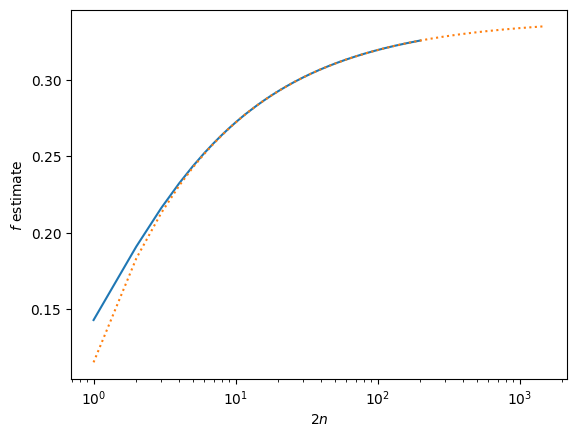

In [64]:
xr = np.arange(len(fdirect))
plt.plot(xr[1:],fdirect[1:])
xr = np.arange(1500)
plt.plot(xr[1:],popt[0]-popt[1]*xr[1:]**-popt[2],ls='dotted')
plt.xscale('log')
plt.xlabel(r'$2n$')
plt.ylabel(r'$f$ estimate')
plt.show()